## Gotta import stuff duh

In [22]:
from icecream import ic
from keras.layers import Dense, Dropout, Input 
from keras.losses import binary_crossentropy
from keras.models import load_model, Sequential, save_model # tba later  # noqa: F401
from keras.optimizers import SGD

import matplotlib.pyplot as plt
from numpy import ndarray
import numpy as np

import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

ic(tf.config.list_physical_devices("GPU"))
pd.set_option('display.max_colwidth', 200)

ic| tf.config.list_physical_devices("GPU"): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading and Preparing the Dataset

1. Load the dataset and setting the columns names to 'Reviews' and 'Sentiment'.

In [23]:
COLUMN_NAMES=['Reviews','Sentiment']
amazon_reviews = pd.read_csv("./KerasResources/amazon_cells_labelled.csv")
amazon_reviews.columns = COLUMN_NAMES

## Data representation

In [24]:
amazon_reviews.head(10)

,Reviews,Sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up right to get decent volume.,0
6,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.",0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


## Classification visualization

1. Create a pandas series object called 'sentiment_count' and assign it the sentiment count of the 'amazon_reviews' dataframe.

In [25]:
sentiment_count = amazon_reviews.Sentiment.value_counts().sort_index(ascending=False)
sentiment_count

Sentiment
1    500
0    500
Name: count, dtype: int64

In [26]:
(pos, neg) = sentiment_count
sentiment_count = pd.DataFrame(data=[pos, neg], index=["Positive", "Negative"], columns=["Sentiment"])
sentiment_count

,Sentiment
Positive,500
Negative,500


We can tell our classification is a balanced one

The `clean()` function is a utility function used for text preprocessing in the notebook. It performs the following operations:

- Converts the text to lowercase.
- Replaces contractions like "don't" with "do not" and "won't" with "will not".
- Removes non-alphanumeric characters and special characters.
- Removes numbers from the text.

In [27]:
def clean(text):
	text = text.lower()
	text = re.sub("don't", "do not", text)
	text = re.sub("won't", "will not", text)
	text = re.sub("\W+", " ", text)
	text = re.sub("\d+", " ", text)
	text = text.strip()
	return text

Applying the function

In [28]:
amazon_reviews.Reviews = amazon_reviews.Reviews.apply(clean)

## Assigning variables for learning, 
X - features<br>
Y - target

In [29]:
X = amazon_reviews.Reviews
Y = amazon_reviews.Sentiment

## Create the vocabulary of the dataset. 
To be used for embedding/lstm layer if/when integrated

In [30]:
vocabulary = set()
for data_point in X:
	for data in data_point.split():
		vocabulary.add(data)

vocabulary = list(vocabulary)

## Get a grasp of what's in our vocabulary

In [31]:
vocabulary[0:5]

['keypad', 'tries', 'center', 'technology', 'bought']

In [32]:
len(vocabulary)

1810

## Create Document Vectors

In [33]:
class TextEncoder:
	_instance = None

	def __new__(cls):
		if cls._instance is None:
			cls._instance = super().__new__(cls)
			cls._instance.tfidf = TfidfVectorizer()
			cls._instance.encoded_X = None
		return cls._instance

	def fit_transform(self, X):
		if self.encoded_X is None:
			self.encoded_X = self.tfidf.fit_transform(X).toarray()
		else:
			raise Exception("Data has already been encoded. Use transform() instead.")

	def transform(self, X):
		if self.encoded_X is None:
			self.encoded_X = self.tfidf.fit_transform(X).toarray()
		else:
			self.encoded_X = self.tfidf.transform(self.clean(X)).toarray()
		return self.encoded_X

	def clean(self, text):
		temp_ = []
		for sentence in text:
			text = sentence.lower()
			sentence = re.sub("don't", "do not", text)
			sentence = re.sub("won't", "will not", sentence)
			sentence = re.sub("\W+", " ", sentence)
			sentence = re.sub("\d+", " ", sentence)
			sentence = sentence.strip()
			temp_.append(sentence)
		return temp_

te = TextEncoder()
if not isinstance(X, ndarray):
	X = te.transform(X)

In [34]:
len(X)

1000

In [35]:
# You can encode y using one hot encoding but i prefer binary crossentropy for binary classification
# Y = pd.get_dummies(Y)

## Train-Test Split

To evaluate the performance of our model, we need to split our dataset into training and testing sets. We will use a 70:30 split, where 70% of the data will be used for training and 30% for testing.

Here's the code to perform the train-test split:


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=32)

In [37]:
num_epochs=100
loss = binary_crossentropy

def custom_loss(y_true, y_pred):
		return loss(y_true, y_pred)

model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(units=64, activation='tanh'))
model.add(Dropout(0.7))
model.add(Dense(units=1, activation='hard_sigmoid')) # for computation efficiency
model.compile(loss=custom_loss, metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.01,
                            momentum=0.9, nesterov=True))
history=model.fit(np.array(X_train), y_train, 
                  epochs=num_epochs, 
                  batch_size=16,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1)

Epoch 1/100


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4736 - loss: 0.6946 - val_accuracy: 0.5400 - val_loss: 0.6891
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5716 - loss: 0.6898 - val_accuracy: 0.6600 - val_loss: 0.6837
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5757 - loss: 0.6832 - val_accuracy: 0.6567 - val_loss: 0.6792
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6475 - loss: 0.6773 - val_accuracy: 0.7400 - val_loss: 0.6734
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6503 - loss: 0.6704 - val_accuracy: 0.7067 - val_loss: 0.6683
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7465 - loss: 0.6580 - val_accuracy: 0.7767 - val_loss: 0.6614
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6977 - loss: 0.6530 - val_accuracy: 0.7333 - val_loss: 0.6554
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7210 - loss: 0.6463 - val_accuracy: 0.7667 - val_loss: 0.

## Let's save the model for good measure!

In [38]:
# I gitignored it because its a big file and I see no point in it, I might point it to a personal domain and store all the .keras files if you want/need? Lmk!
save_model(model=model, filepath="KerasResources/.keras")

## Show the learning curves

1. Loss vs Epoch (training and validation)
2. Accuracy vs Epoch (training and validation)

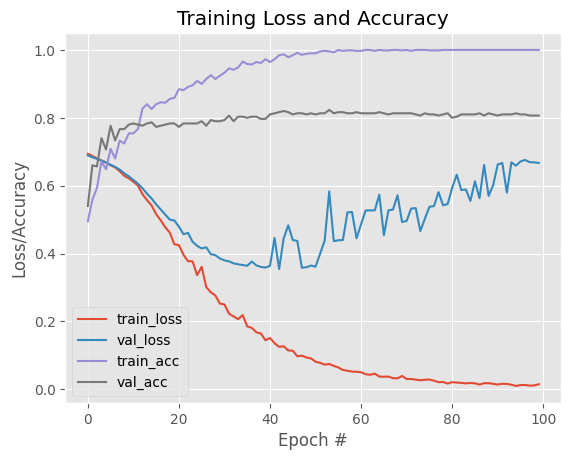

In [39]:
def plot_graphs(H, metric):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #" )
  plt.ylabel("Loss/Accuracy" )
  plt.legend()
  plt.savefig("./KerasResources/model history.png")
  plt.show( )
plot_graphs(history,'acc')

## Predicting with a loaded Model!

To evaluate the performance of our model on the test set (`X_test`), we can use the `predict()` method of the model. Here's the code to predict the model on `X_test`:

In [48]:
lm = load_model("KerasResources/.keras", compile=False, custom_objects={'custom_loss': custom_loss})

In [49]:
preds = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [50]:
preds=[round(each[0]) for each in preds]
y_test_cm= [each for each in y_test]

## Confusion Matrix analysis 

In [51]:
cm = confusion_matrix(y_true=y_test_cm, y_pred=preds)
df_cm = pd.DataFrame(data=cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
df_cm.head()

,Negative,Positive
Negative,130,25
Positive,33,112


## Classification Report analysis

In [52]:
print(classification_report(y_true=y_test_cm, y_pred=preds))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       155
           1       0.82      0.77      0.79       145

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



### Make Prediction On New Text Reviews

To predict whether the following text reviews are positive or negative and provide the probability in %, you can use the `predict_results()` function. Here's the code:

In [56]:
newPositiveText='I think this movie is eh honestly.'
newNegativeText='This show is the worst show in the century. Oh my god it was TERRIBLE'


In [57]:
def predict_results(text):
  pred=model.predict(te.transform([text]))
  if round(pred[0][0]) ==1:
    print("'{}'".format(text))
    print('Prediction: Positive {:.2%}'.format(pred[0][0]) )
  else:
    print("'{}'".format(text))
    print('Prediction: Negative {:.2%}'.format(pred[0][0]) )
predict_results(newPositiveText)
predict_results(newNegativeText)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


'I think this movie is eh honestly.'
Prediction: Positive 80.11%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
'This show is the worst show in the century. Oh my god it was TERRIBLE'
Prediction: Negative 0.00%
